# Inferencia Bayesiana Entrega 2: Matias Moran LU 806/19

## Ejercicio 1

Supongamos que uno tiene una variable aleatoria Y que puede modelar con una distribucion
geométrica. Es decir que $P(Y = y | \theta) = \theta (1—\theta)^{y-1}$ para $y \in \{ 1,2,3,.. \}.$ Se utiliza un prior
$\Beta(a, b)$ para $\theta$.

### A) Qué situacion se representa con una variable aleatoria geométrica?

La variable aleatoria geometrica se usa para representar una distribucion similar a la binomial pero donde queremos saber "Cuantos experimentos de bernoulli con probabilidad p de exito tengo que hacer hasta obtener un exito".

por ejemplo cuantas monedas tengo que tirar hasta sacar cara, cuantos dados tengo que tirar hasta que salga un 3, etc

### B) Derivar la distribucion posterior para $\theta$ suponiendo que se observé $Y = y$. Identificar la distribucion encontrada y sus parametros.

$P(\theta | Y = y) = \frac{P(Y = y| \theta) \cdot L(\theta)}{P(Y = y)}$

$P(\theta | Y = y) = \frac{f(\theta) \cdot f(\theta | Y = y)}{P(Y = y)}$

$P(\theta | Y = y) = \frac{f(\theta) \cdot (1-\theta)^{y-1} \cdot \theta}{P(Y = y)}$

$P(\theta | Y = y) \propto f(\theta) \cdot (1-\theta)^{y-1} \cdot \theta$

Vemos que la forma $(1-\theta)^{y-1} \cdot \theta$ se asemeja mucho a la pdf de la Beta, asi que vamos a probar un prior $\Beta(a,b)$

$P(\theta | Y = y) \propto (1-\theta)^{b-1} \cdot \theta^{a-1} \cdot (1-\theta)^{y-1} \cdot \theta$

$P(\theta | Y = y) \propto (1-\theta)^{b+y-2} \cdot \theta^{a}$

$P(\theta | Y = y) \propto B(a + 1, b + y - 1)$

> **_NOTA:_**
La razon porque la geometrica es tambien una distribucion conjugada de la Beta es porque es un "caso particular" de la distribucion binomial para k=1 (exitos igual a 1) y donde en vez de multiplicarlo por el numero de posibles permutaciones $\binom{n}{1}$ simplemente se omite esta constante porque el exito siempre esta en la ultima posicion y como esto es una constante se va cuando normalizamos la posterior ya que sigue siendo proporcional

### C) El modelo Beta es un prior conjugado de la Geométrica?

Si, vimos que si tenemos un prior beta y nuestra distribucion es geometrica nuestro post tambien es Beta, asi que es un prior conjugado

## Ejercicio 2

Identificar una pregunta que se pueda responder con un modelo de regresion lineal con
$\beta_{0}. \beta_{1} ,\sigma$ como parametros a estimar. Por ejemplo puede ser, altura del hijo en funcion de
altura de la madre, velocidad maxima de un auto en funcion de caballos de fuerza, etc.
Usatus propios datos o simulalos.

$$Y_{i} \sim \mathcal{N}(\mu(x_{i}), \sigma^{2})$$

$$\mu = \beta_{0} + \beta_{1} \cdot x_{i}$$


> **_DATASETS:_**
Los dataset que vamos a utilizar son 3.
- 1 vamos a utilizar la informacion de alquiler de bicicletas en Washinton DC en funcion de la temperatura, este es un ejemplo del capitulo 9 del libro de Bayes rules.
- 2 vamos a utilizar el dataset de Galton que compara las alturas de los padres con los hijos 
- 3 a modo experimental vamos a usar las estadisticas de 1400 jugadores actuales de las ligas europeas de futbol, vamos a tratar de comparar las estadisticas de goles, asistencias y minutos jugados para ver si tienen relacion lineal con el valor de mercado mas alto que tuvo cada jugador, vamos a notar que en este caso las distribuciones no son normales.

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import concurrent.futures as theads_futures

from scipy.stats import beta, norm, expon
from matplotlib.lines import Line2D
from IPython.display import Markdown

np.random.seed(42)
logging.basicConfig(level=logging.INFO)

In [2]:
#https://www.kaggle.com/datasets/marklvl/bike-sharing-dataset?resource=download
df_bikes = pd.read_csv('../../sandbox/bikes/day.csv')

# temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
#unormalize temperatures
df_bikes.temp = (39 - (-8)) * df_bikes.temp + (-8)
df_bikes

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,8.175849,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,9.083466,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,1.229108,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,1.400000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,2.666979,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,3.945849,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,3.906651,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,3.906651,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,4.024151,0.231700,0.483333,0.350754,364,1432,1796


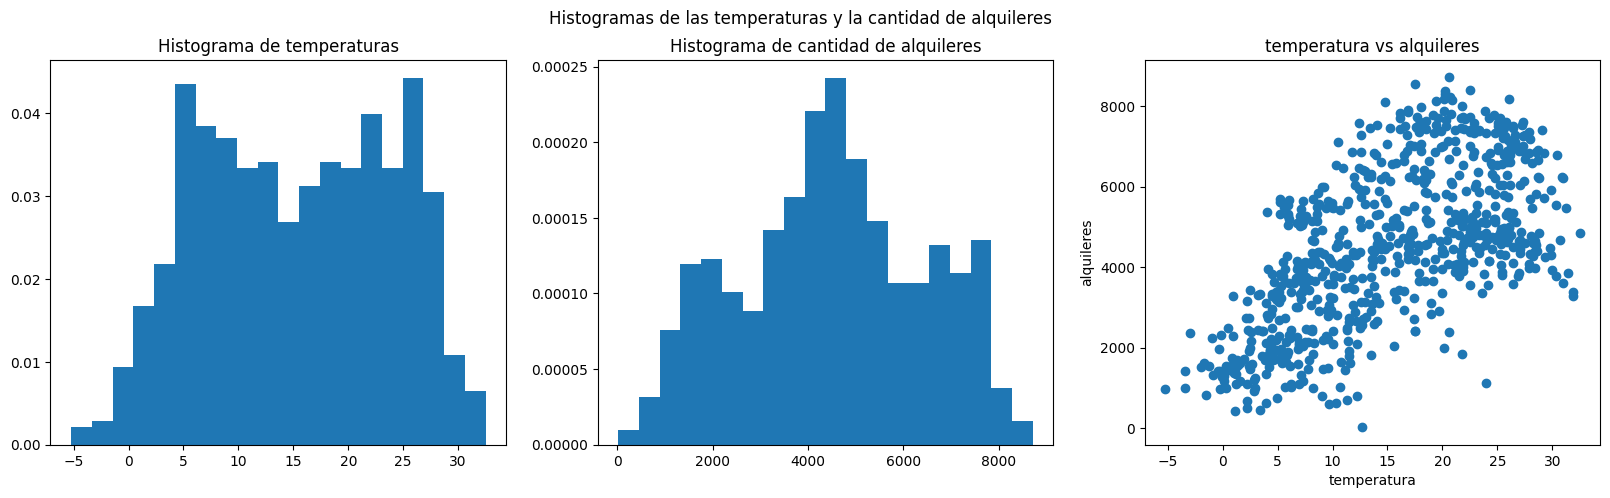

In [3]:
bins_n=20

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Histogramas de las temperaturas y la cantidad de alquileres')

ax[0].plot()
ax[0].set_title('Histograma de temperaturas')
ax[0].hist(df_bikes.temp, bins=bins_n, density=True)

ax[1].plot()
ax[1].set_title('Histograma de cantidad de alquileres')
ax[1].hist(df_bikes.cnt, bins=bins_n, density=True)

ax[2].plot()
ax[2].set_title('temperatura vs alquileres')
ax[2].scatter(df_bikes.temp, df_bikes.cnt)
ax[2].set_xlabel('temperatura')
ax[2].set_ylabel('alquileres')

plt.show()

In [4]:
#https://www.kaggle.com/datasets/jacopoferretti/parents-heights-vs-children-heights-galton-data?select=GaltonFamilies.csv
df_height = pd.read_csv('../../sandbox/parents_children_heights/GaltonFamilies.csv')
df_height

,rownames,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,001,78.5,67.0,75.43,4,1,male,73.2
1,2,001,78.5,67.0,75.43,4,2,female,69.2
2,3,001,78.5,67.0,75.43,4,3,female,69.0
3,4,001,78.5,67.0,75.43,4,4,female,69.0
4,5,002,75.5,66.5,73.66,4,1,male,73.5
...,...,...,...,...,...,...,...,...,...
929,930,203,62.0,66.0,66.64,3,1,male,64.0
930,931,203,62.0,66.0,66.64,3,2,female,62.0
931,932,203,62.0,66.0,66.64,3,3,female,61.0
932,933,204,62.5,63.0,65.27,2,1,male,66.5


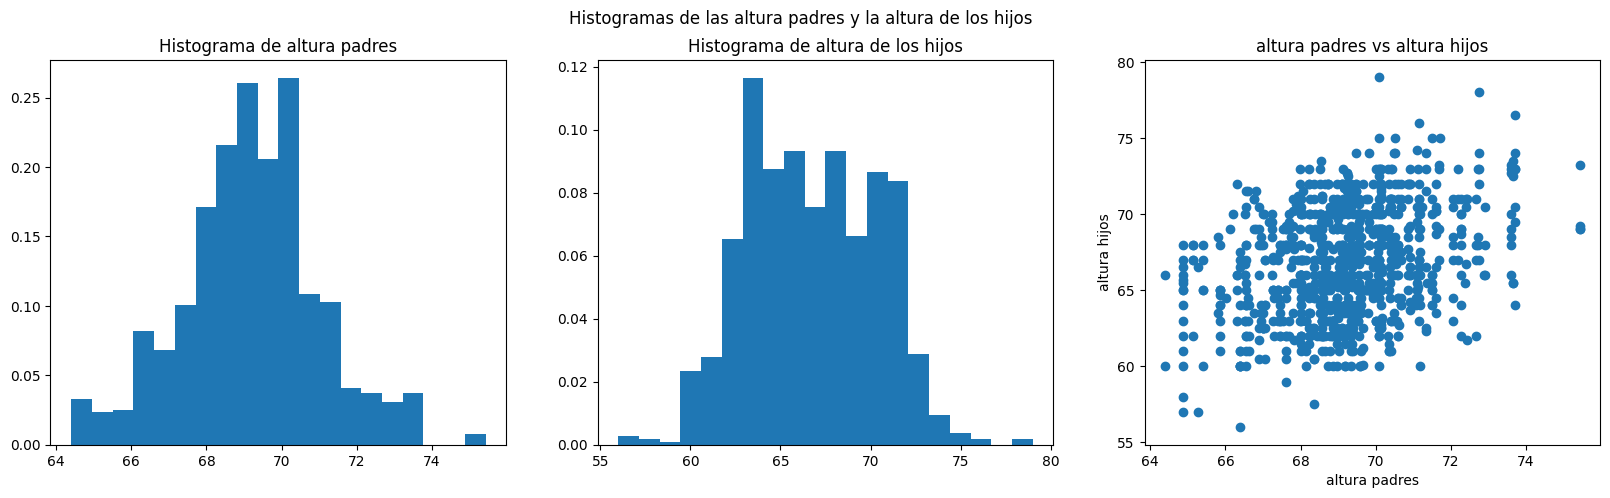

In [5]:
bins_n=20

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Histogramas de las altura padres y la altura de los hijos')

ax[0].plot()
ax[0].set_title('Histograma de altura padres')
ax[0].hist(df_height.midparentHeight, bins=bins_n, density=True,)

ax[1].plot()
ax[1].set_title('Histograma de altura de los hijos')
ax[1].hist(df_height.childHeight, bins=bins_n, density=True)

ax[2].plot()
ax[2].set_title('altura padres vs altura hijos')
ax[2].scatter(df_height.midparentHeight, df_height.childHeight)
ax[2].set_xlabel('altura padres')
ax[2].set_ylabel('altura hijos')

plt.show()

In [6]:
#https://www.kaggle.com/datasets/davidcariboo/player-scores
df_players = pd.read_csv('../../sandbox/football/player_stats/player_stats.csv')
df_players

,Unnamed: 0,player_id,goals,assists,minutes_played,first_name,last_name,name,last_season,current_club_id,...,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur,log_minutes_played,log_highest_value
0,0,3333,38,70,25686,James,Milner,James Milner,2023,1237,...,2025-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/james-milner/p...,GB1,Brighton & Hove Albion,1000000.0,21000000.0,10.153701,16.860033
1,1,7161,64,78,20209,Jonas,Hofmann,Jonas Hofmann,2023,15,...,2027-06-30 00:00:00,Dr. Marco Gutfleisch,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/jonas-hofmann/...,L1,Bayer 04 Leverkusen,10000000.0,16000000.0,9.913883,16.588099
2,2,16306,42,37,32078,NaN,Casemiro,Casemiro,2023,985,...,2026-06-30 00:00:00,Best of You,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/casemiro/profi...,GB1,Manchester United,20000000.0,80000000.0,10.375926,18.197537
3,3,18644,107,41,20270,Álvaro,Negredo,Álvaro Negredo,2023,2687,...,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/alvaro-negredo...,ES1,Cádiz CF,300000.0,27000000.0,9.916897,17.111347
4,4,20005,82,89,30184,NaN,Papu Gómez,Papu Gómez,2023,2919,...,NaN,GR Sports,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/papu-gomez/pro...,IT1,AC Monza,2000000.0,18000000.0,10.315067,16.705882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,1408,1111663,1,0,34,Kingstone,Mutandwa,Kingstone Mutandwa,2023,1390,...,2027-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/kingstone-muta...,IT1,Cagliari Calcio,1000000.0,1000000.0,3.526361,13.815511
1409,1409,1184137,0,0,2,Yassin,Tallal,Yassin Tallal,2023,3709,...,2026-06-30 00:00:00,MIV GESTFUT,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/yassin-tallal/...,ES1,Getafe CF,50000.0,50000.0,0.693147,10.819778
1410,1410,1210422,0,0,45,Aboubacar,Bassinga,Aboubacar Bassinga,2023,472,...,NaN,Gesport Espizua SL,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/aboubacar-bass...,ES1,UD Las Palmas,NaN,NaN,3.806662,NaN
1411,1411,1230202,0,0,3,Borja,Vázquez,Borja Vázquez,2023,2687,...,2026-06-30 00:00:00,Gesport Espizua SL,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/borja-vazquez/...,ES1,Cádiz CF,50000.0,50000.0,1.098612,10.819778


In [7]:
df_players = df_players[df_players["minutes_played"] > 500]
df_players = df_players[df_players["goals"].notna()]
df_players = df_players[df_players["goals"] > 0]
df_players['log_goals'] = np.log(df_players["goals"])
df_players = df_players[df_players["assists"].notna()]
df_players = df_players[df_players["assists"] > 0]
df_players['log_assists'] = np.log(df_players["assists"])
df_players = df_players[df_players["log_minutes_played"].notna()]
df_players = df_players[df_players["log_highest_value"].notna()]
df_players = df_players[['goals', 'log_goals', 'assists', 'log_assists', 'log_minutes_played', 'log_highest_value']]
df_players

,goals,log_goals,assists,log_assists,log_minutes_played,log_highest_value
0,38,3.637586,70,4.248495,10.153701,16.860033
1,64,4.158883,78,4.356709,9.913883,16.588099
2,42,3.737670,37,3.610918,10.375926,18.197537
3,107,4.672829,41,3.713572,9.916897,17.111347
4,82,4.406719,89,4.488636,10.315067,16.705882
...,...,...,...,...,...,...
1331,4,1.386294,2,0.693147,7.261927,14.403297
1334,2,0.693147,2,0.693147,7.631917,17.147715
1342,7,1.945910,9,2.197225,7.994295,18.603002
1371,5,1.609438,2,0.693147,7.821242,16.705882


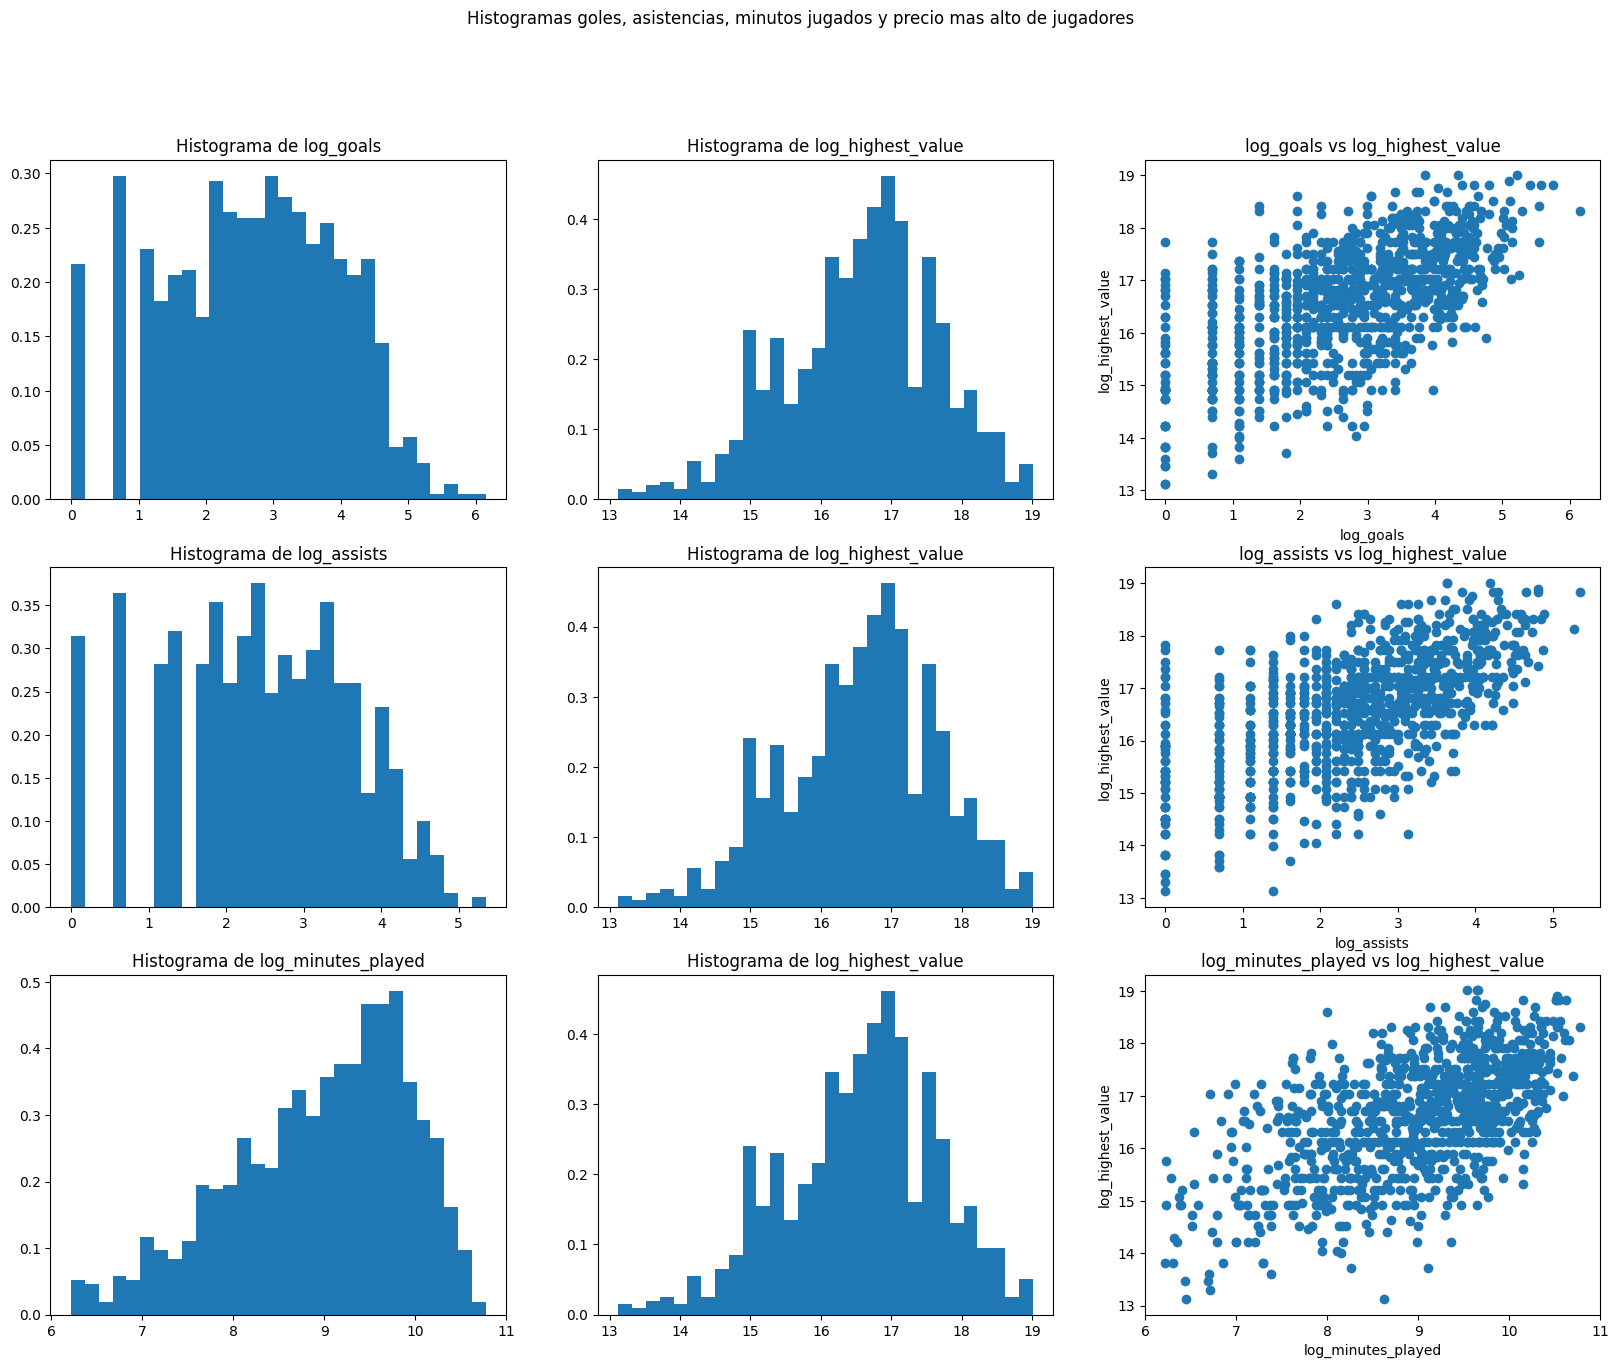

In [8]:
bins_n=30

fig, ax = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Histogramas goles, asistencias, minutos jugados y precio mas alto de jugadores')

for i, col in enumerate(['log_goals', 'log_assists', 'log_minutes_played']):
    ax[i,0].plot()
    ax[i,0].set_title(f'Histograma de {col}')
    ax[i,0].hist(df_players[col], bins=bins_n, density=True)

    ax[i,1].plot()
    ax[i,1].set_title('Histograma de log_highest_value')
    ax[i,1].hist(df_players.log_highest_value, bins=bins_n, density=True)

    ax[i,2].plot()
    ax[i,2].set_title(f'{col} vs log_highest_value')
    ax[i,2].scatter(df_players[col], df_players.log_highest_value)
    ax[i,2].set_xlabel(col)
    ax[i,2].set_ylabel('log_highest_value')

plt.show()

- Podemos observar que las variables de goles y asistencias parecen seguir una distribucion exponencial mientras que la variable de minutos jugados parece seguir una distribucion beta o una algo parecido a una normal inclinada mientras que los precios mas altos historicos para cada jugador sigue una normal

### A) Proponer priors para $\beta_{0}. \beta_{1} ,\sigma$



Para el caso de las bicicletas vamos a basarnos en el libro de bayes rules y vamos a hacer la regresion de temperatura vs cantidad de bicicletas alquiladas diarias poniendo priors normales a los parametros de la relacion lineal y un parametro exponencial para sigma para limitar el rango a que solo sea de valores positivos

$$
\text{data:} \quad Y_{i}|\beta_{0}, \beta_{1} ,\sigma \sim \mathcal{N}(\mu_{i}, \sigma^{2}) \quad  \text{with} \quad  \mu(x_{i}) = \beta_{0} + \beta_{1} \cdot X_{i}
$$

$$
\text{priors:} \quad \beta_{0} \sim \mathcal{N}(m_{0}, s^{2}_{0})
$$
$$
\quad \quad \quad \quad \beta_{1} \sim \mathcal{N}(m_{1}, s^{2}_{1})
$$
$$
\quad \quad \quad \sigma \sim Exp(l)
$$


Para el caso de las alturas de los padres vs hijos vamos a tener el mismo aproach pero en vez de usar una distribucion exponencial para sigma vamos a usar la mitad positiva de una normal como hicimos en clase

$$
\text{data:} \quad Y_{i}|\beta_{0}, \beta_{1} ,\sigma \sim \mathcal{N}(\mu_{i}, \sigma^{2}) \quad  \text{with} \quad  \mu(x_{i}) = \beta_{0} + \beta_{1} \cdot X_{i}
$$

$$
\text{priors:} \quad \beta_{0} \sim \mathcal{N}(m_{0}, s^{2}_{0})
$$
$$
\quad \quad \quad \quad \beta_{1} \sim \mathcal{N}(m_{1}, s^{2}_{1})
$$
$$
\quad \quad \quad \sigma \sim \mathcal{N}^{+}(m_{2}, s^{2}_{2})
$$

Para el tercer caso de las comparaciones vamos a setear priors normales a los logaritmos de la cantidad de goles, asistencias, minutos totales jugados y al precio mas alto historico que un jugador tuvo

$$
\text{data:} \quad Y_{i}|\beta_{0}, \beta_{1} ,\beta_{2} ,\beta_{3} ,\sigma \sim \mathcal{N}(\mu_{i}, \sigma^{2}) \quad  \text{with} \quad  \mu(x_{i}) = \beta_{0} + \beta_{1} \cdot G_{i} + \beta_{2} \cdot A_{i} + \beta_{3} \cdot M_{i}
$$

$$
\text{priors:} \quad \beta_{0} \sim \mathcal{N}(m_{0}, s^{2}_{0})
$$
$$
\quad \quad \quad \quad \beta_{1} \sim \mathcal{N}(m_{1}, s^{2}_{1})
$$
$$
\quad \quad \quad \quad \beta_{2} \sim \mathcal{N}(m_{2}, s^{2}_{2})
$$
$$
\quad \quad \quad \quad \beta_{3} \sim \mathcal{N}(m_{3}, s^{2}_{3})
$$
$$
\quad \quad \quad \sigma \sim \mathcal{N}^{+}(m_{4}, s^{2}_{4})
$$

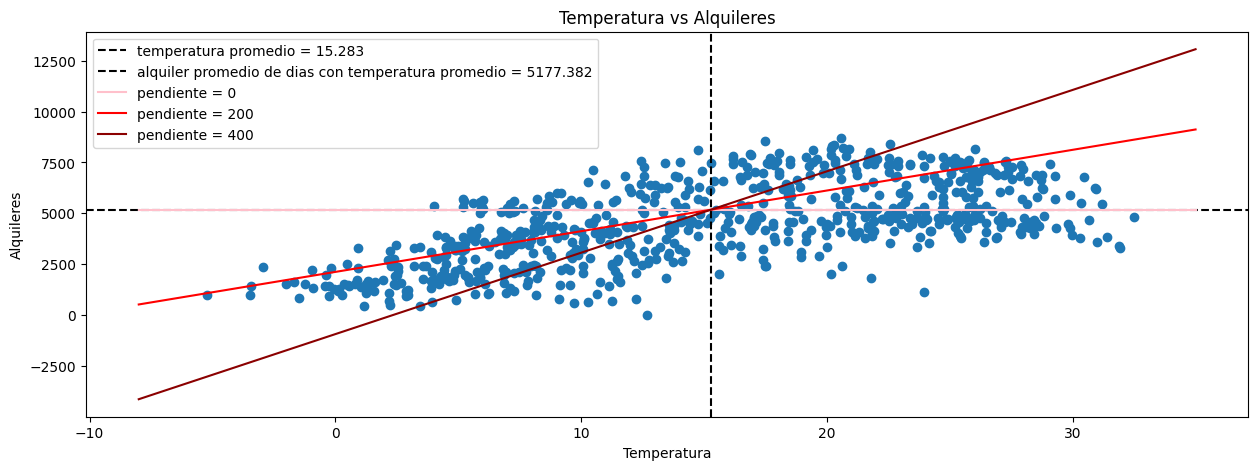


Para el caso de las bicicletas, podemos ver:

- en un dia promedio de 15.283 de temperatura, El alquier de bicicletas es de 5177.382 con una desviacion de hasta 1817 y 8555
esto nos dice que $\beta_{0} \sim \mathcal{N}(5177.382, 3000^{2})$ donde estamos centrando los datos en en el origen como lo indican las lineas punteadas negras

- por cada aumento de 5 en el valor de la temperatura la cantidad de bicicletas alquiladas sube en 200 aproximadamente y esto puede variar entre a lo sumo 0 y 400 como lo representan las rectas marcadas en rojo, esto nos dice que $\beta_{1} \sim \mathcal{N}(200, 200^{2})$ es una distribucion razonable

- en un dia cualquiera cantidad de alquileres tiene una rango que puede ser de $\pm$ 3000 alquileres como sabemos que 3 desviaciones estandard deberia contener a casi todos los datos deducimos que la desviacion estandar es de $\frac{3000}/3 = 1000$<br>.
esto nos dice que podemos modelar nuestro $\sigma$ para que su expected value sea 1000.<br>
$E(\sigma) = \frac{1}{l} = 1000 \implies l = 0.001$


Finalmente tenemos los priors:


$$
\text{data:} \quad Y_{i}|\beta_{0}, \beta_{1} ,\sigma \sim \mathcal{N}(\mu_{i}, \sigma^{2}) \quad  \text{with} \quad  \mu(x_{i}) = \beta_{0} + \beta_{1} \cdot X_{i}
$$

$$
\text{priors:} \quad \beta_{0} \sim \mathcal{N}(5177.382, 3000^{2})
$$
$$
\quad \quad \quad \quad \beta_{1} \sim \mathcal{N}(200, 200^{2})
$$
$$
\quad \quad \quad \sigma \sim Exp(0.001)
$$



In [9]:
bins_n=20

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.set_title('Temperatura vs Alquileres')
ax.scatter(df_bikes.temp, df_bikes.cnt)
ax.set_xlabel('Temperatura')
ax.set_ylabel('Alquileres')

# Calculamos la temperatura media y la media de la cantidad de bicicletas alquiladas en ese dia para los datos que tienen una temperatura cercana a la media
mean_temperature = round(df_bikes.temp.mean(), 3)
average_temperature_samples = df_bikes[np.isclose(df_bikes.temp, np.full_like(df_bikes.temp, mean_temperature), atol= np.full_like(df_bikes.temp, 2.5))]
mean_rides = round(average_temperature_samples.cnt.mean(), 3)

ax.axvline(x=mean_temperature, color='black', linestyle='--', label=f'temperatura promedio = {mean_temperature}')
ax.axhline(y=mean_rides, color='black', linestyle='--', label=f'alquiler promedio de dias con temperatura promedio = {mean_rides}')


x = np.linspace(-8, 35, 400)
y = 0/5 * (x - mean_temperature) + mean_rides
plt.plot(x, y, label='pendiente = 0', color='pink')
y = 1000/5 * (x - mean_temperature) + mean_rides
plt.plot(x, y, label='pendiente = 200', color='red')
y = 2000/5 * (x - mean_temperature) + mean_rides
plt.plot(x, y, label='pendiente = 400', color='darkred')


ax.legend()
plt.show()


Markdown(fr"""
Para el caso de las bicicletas, podemos ver:

- en un dia promedio de {mean_temperature} de temperatura, El alquier de bicicletas es de {mean_rides} con una desviacion de hasta {average_temperature_samples.cnt.min()} y {average_temperature_samples.cnt.max()}
esto nos dice que $\beta_{{0}} \sim \mathcal{{N}}({mean_rides}, 3000^{{2}})$ donde estamos centrando los datos en en el origen como lo indican las lineas punteadas negras

- por cada aumento de 5 en el valor de la temperatura la cantidad de bicicletas alquiladas sube en 200 aproximadamente y esto puede variar entre a lo sumo 0 y 400 como lo representan las rectas marcadas en rojo, esto nos dice que $\beta_{{1}} \sim \mathcal{{N}}(200, 200^{{2}})$ es una distribucion razonable

- en un dia cualquiera cantidad de alquileres tiene una rango que puede ser de $\pm$ 3000 alquileres como sabemos que 3 desviaciones estandard deberia contener a casi todos los datos deducimos que la desviacion estandar es de $\frac{{3000}}/3 = 1000$<br>.
esto nos dice que podemos modelar nuestro $\sigma$ para que su expected value sea 1000.<br>
$E(\sigma) = \frac{{1}}{{l}} = 1000 \implies l = {round(1/1000, 6)}$


Finalmente tenemos los priors:


$$
\text{{data:}} \quad Y_{{i}}|\beta_{{0}}, \beta_{{1}} ,\sigma \sim \mathcal{{N}}(\mu_{{i}}, \sigma^{{2}}) \quad  \text{{with}} \quad  \mu(x_{{i}}) = \beta_{{0}} + \beta_{{1}} \cdot X_{{i}}
$$

$$
\text{{priors:}} \quad \beta_{{0}} \sim \mathcal{{N}}({mean_rides}, 3000^{{2}})
$$
$$
\quad \quad \quad \quad \beta_{{1}} \sim \mathcal{{N}}(200, 200^{{2}})
$$
$$
\quad \quad \quad \sigma \sim Exp({round(1/1000, 6)})
$$

""")


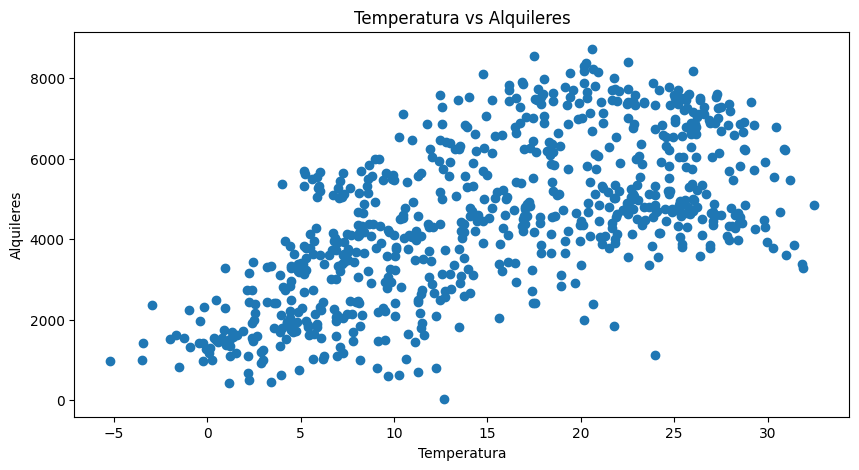

In [10]:
bins_n=20

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.set_title('Temperatura vs Alquileres')
ax.scatter(df_bikes.temp, df_bikes.cnt)
ax.set_xlabel('Temperatura')
ax.set_ylabel('Alquileres')

plt.show()

In [11]:
beta_0_mean = mean_rides
beta_0_std = 3000

beta_1_mean = 200
beta_1_std = 200

sigma_scale = 1000

## B) Escribir la likelihood de los datos de forma analitica en funcion de los parametros.

La Likehood de los parametros en funcion de los datos $\overrightarrow{y} = (y_{1},y_{2},...,y_{n})$ se puede definir como $L(\beta_{{0}}, \beta_{{1}} ,\sigma|\overrightarrow{y}) = f(\overrightarrow{y}|\beta_{{0}}, \beta_{{1}} ,\sigma) = \prod_{i=1}^{n} f(y_{i}|\beta_{{0}}, \beta_{{1}} ,\sigma)$

## C) Implementar el algoritmo de Metrépolis (MCMC) y generar 5.000 samples del posterior sin descontar el tramo inicial de la cadena (burn = 0).

In [12]:
def metropolis_hasting(log_posterior, proposal_function, initial_candidate, num_samples):
    result_chain = np.zeros(shape=(num_samples, len(initial_candidate)))
    result_chain[0] = initial_candidate

    for i in range(1, num_samples):
        if i % 100 == 0:
            logging.info(f'iteracion {i}')

        next_candidate = proposal_function(result_chain[i-1])
        log_acceptance_ratio = log_posterior(next_candidate) - log_posterior(result_chain[i-1])

        if log_acceptance_ratio >= 0:
            result_chain[i] = next_candidate
            continue

        if np.log(np.random.rand()) < log_acceptance_ratio:
            result_chain[i] = next_candidate
        else:
            result_chain[i] = result_chain[i-1]
    
    return result_chain

# hacemos que el siguiente candidato sea normalmente distribuido con media = current_candidate y desviacion = std ya que a lo sumo puede caer en [current_candidate - 3*std, current_candidate + 3*std]
# en la mayoria de los casos (3 desviaciones estadard).
# para beta_0, beta_1 y sigma elegimos std de dos ordenes de magnitud mas chicos
def bikes_normal_proposal(current_candidate):
    new_beta_0 = np.random.normal(current_candidate[0], 10)
    new_beta_1 = np.random.normal(current_candidate[1], 1)
    new_sigma = np.random.normal(current_candidate[2], 10)
    return [new_beta_0, new_beta_1, new_sigma]

def bikes_log_posterior_unnormalize(candidate):
    log_prior = np.log(norm.pdf(candidate[0], beta_0_mean, beta_0_std)) + np.log(norm.pdf(candidate[1], beta_1_mean, beta_1_std)) + np.log(expon.pdf(candidate[2], scale=sigma_scale))

    temps = df_bikes['temp'].values
    cnts = df_bikes['cnt'].values
    
    predicted = candidate[0] + candidate[1] * temps
    
    log_likehoods = np.log(norm.pdf(cnts, predicted, candidate[2]))

    log_likehood = np.sum(log_likehoods)

    return log_prior + log_likehood

In [13]:
bike_chain_1 = metropolis_hasting(bikes_log_posterior_unnormalize, bikes_normal_proposal, [beta_0_mean, beta_1_mean, sigma_scale], 5000)
bike_chain_1

INFO:root:iteracion 100
INFO:root:iteracion 200
INFO:root:iteracion 300
INFO:root:iteracion 400
INFO:root:iteracion 500
INFO:root:iteracion 600
INFO:root:iteracion 700
INFO:root:iteracion 800
INFO:root:iteracion 900
INFO:root:iteracion 1000
INFO:root:iteracion 1100
INFO:root:iteracion 1200
INFO:root:iteracion 1300
INFO:root:iteracion 1400
INFO:root:iteracion 1500
INFO:root:iteracion 1600
INFO:root:iteracion 1700
INFO:root:iteracion 1800
INFO:root:iteracion 1900
INFO:root:iteracion 2000
INFO:root:iteracion 2100
INFO:root:iteracion 2200
INFO:root:iteracion 2300
INFO:root:iteracion 2400
INFO:root:iteracion 2500
INFO:root:iteracion 2600
INFO:root:iteracion 2700
INFO:root:iteracion 2800
INFO:root:iteracion 2900
INFO:root:iteracion 3000
INFO:root:iteracion 3100
INFO:root:iteracion 3200
INFO:root:iteracion 3300
INFO:root:iteracion 3400
INFO:root:iteracion 3500
INFO:root:iteracion 3600
INFO:root:iteracion 3700
INFO:root:iteracion 3800
INFO:root:iteracion 3900
INFO:root:iteracion 4000
INFO:root

array([[5177.382     ,  200.        , 1000.        ],
       [5182.34914153,  199.8617357 , 1006.47688538],
       [5182.34914153,  199.8617357 , 1006.47688538],
       ...,
       [2387.93826653,  143.39955507, 1563.73427966],
       [2388.73867922,  144.72195939, 1545.74071285],
       [2402.67670274,  145.60332382, 1562.17547556]])

## D) Graficar la cadena resultante (en 3d para todo el posterior o independientemente para cada parametro en 3 graficos distintos). Parece haber convergido la cadena?

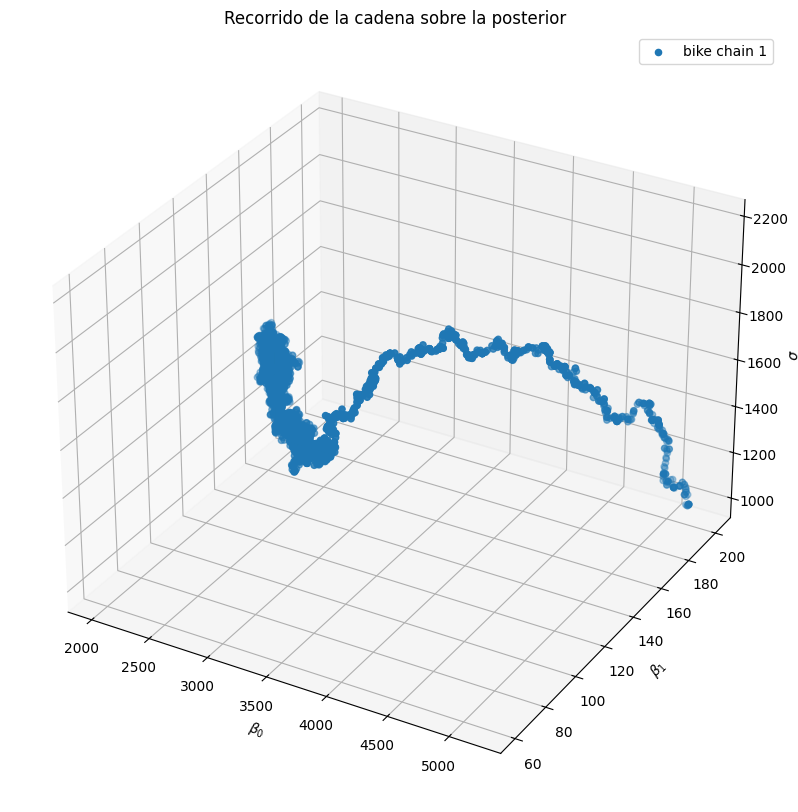



## La cadena parece haber convergido y estabilizado



In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(bike_chain_1[:, 0], bike_chain_1[:, 1], bike_chain_1[:, 2], label='bike chain 1')

ax.set_xlabel(r'$\beta_{0}$')
ax.set_ylabel(r'$\beta_{1}$')
ax.set_zlabel(r'$\sigma$')
ax.set_title('Recorrido de la cadena sobre la posterior')

ax.legend()
plt.show()


Markdown(fr"""

#### La cadena parece haber convergido y estabilizado

""")

## E) Repetir el inciso c) y d) para 3 cadenas paralelas. Grafiquelas superpuestas con colores distintos. Cuantos samples tarda en llegar a estado de equilibrio (a ojo)?

In [15]:
arguments = [
    (bikes_log_posterior_unnormalize, bikes_normal_proposal, [1000, 60, 1000], 5000),
    (bikes_log_posterior_unnormalize, bikes_normal_proposal, [1000, 200, 1800], 5000),
    (bikes_log_posterior_unnormalize, bikes_normal_proposal, [5000, 60, 1000], 5000),
    (bikes_log_posterior_unnormalize, bikes_normal_proposal, [5000, 200, 1000], 5000),
]

with theads_futures.ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(metropolis_hasting, *args) for args in arguments]
    theads_futures.wait(futures)
    bike_chains = [future.result() for future in futures]

INFO:root:iteracion 100
INFO:root:iteracion 100
INFO:root:iteracion 100
INFO:root:iteracion 100
INFO:root:iteracion 200
INFO:root:iteracion 200
INFO:root:iteracion 200
INFO:root:iteracion 200
INFO:root:iteracion 300
INFO:root:iteracion 300
INFO:root:iteracion 300
INFO:root:iteracion 300
INFO:root:iteracion 400
INFO:root:iteracion 400
INFO:root:iteracion 400
INFO:root:iteracion 400
INFO:root:iteracion 500
INFO:root:iteracion 500
INFO:root:iteracion 500
INFO:root:iteracion 500
INFO:root:iteracion 600
INFO:root:iteracion 600
INFO:root:iteracion 600
INFO:root:iteracion 600
INFO:root:iteracion 700
INFO:root:iteracion 700
INFO:root:iteracion 700
INFO:root:iteracion 700
INFO:root:iteracion 800
INFO:root:iteracion 800
INFO:root:iteracion 800
INFO:root:iteracion 800
INFO:root:iteracion 900
INFO:root:iteracion 900
INFO:root:iteracion 900
INFO:root:iteracion 900
INFO:root:iteracion 1000
INFO:root:iteracion 1000
INFO:root:iteracion 1000
INFO:root:iteracion 1000
INFO:root:iteracion 1100
INFO:root:i

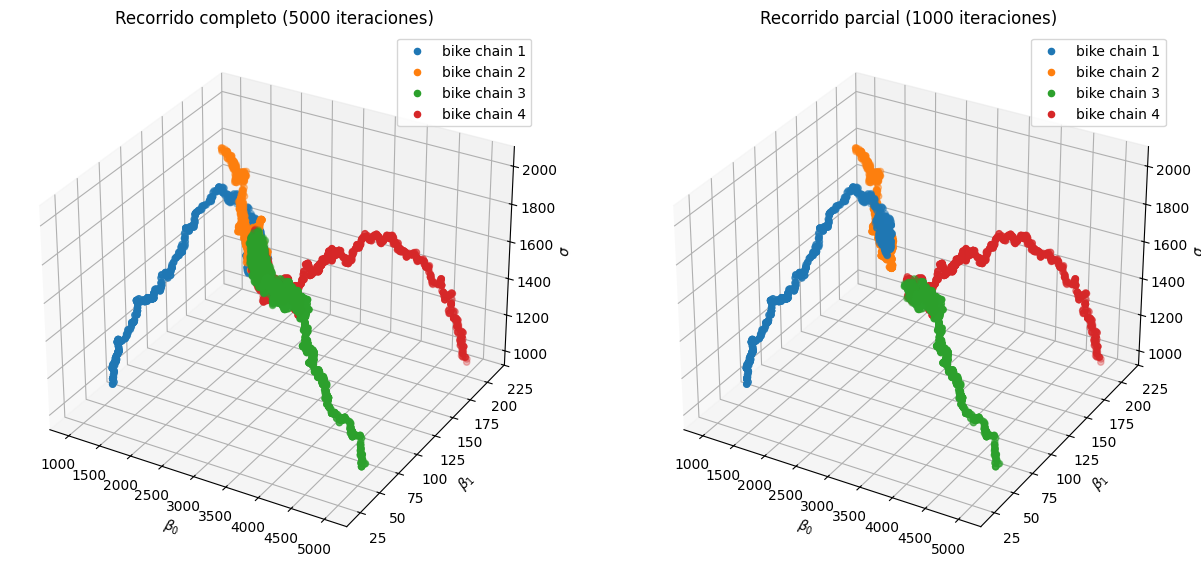



## Vemos que las cadenas se mezclan y se estabilizan a partir de las 1000 iteraciones aproximadamente



In [16]:
fig = plt.figure(figsize=(15,15))

ax0 = fig.add_subplot(121, projection='3d')

ax0.scatter(bike_chains[0][:, 0], bike_chains[0][:, 1], bike_chains[0][:, 2], label='bike chain 1')
ax0.scatter(bike_chains[1][:, 0], bike_chains[1][:, 1], bike_chains[1][:, 2], label='bike chain 2')
ax0.scatter(bike_chains[2][:, 0], bike_chains[2][:, 1], bike_chains[2][:, 2], label='bike chain 3')
ax0.scatter(bike_chains[3][:, 0], bike_chains[3][:, 1], bike_chains[3][:, 2], label='bike chain 4')

ax0.set_xlabel(r'$\beta_{0}$')
ax0.set_ylabel(r'$\beta_{1}$')
ax0.set_zlabel(r'$\sigma$')
ax0.set_title('Recorrido completo (5000 iteraciones)')

ax0.legend()

ax1 = fig.add_subplot(122, projection='3d')

convergence_iterations = 1000

ax1.scatter(bike_chains[0][:convergence_iterations, 0], bike_chains[0][:convergence_iterations, 1], bike_chains[0][:convergence_iterations, 2], label='bike chain 1')
ax1.scatter(bike_chains[1][:convergence_iterations, 0], bike_chains[1][:convergence_iterations, 1], bike_chains[1][:convergence_iterations, 2], label='bike chain 2')
ax1.scatter(bike_chains[2][:convergence_iterations, 0], bike_chains[2][:convergence_iterations, 1], bike_chains[2][:convergence_iterations, 2], label='bike chain 3')
ax1.scatter(bike_chains[3][:convergence_iterations, 0], bike_chains[3][:convergence_iterations, 1], bike_chains[3][:convergence_iterations, 2], label='bike chain 4')

ax1.set_xlabel(r'$\beta_{0}$')
ax1.set_ylabel(r'$\beta_{1}$')
ax1.set_zlabel(r'$\sigma$')
ax1.set_title(f'Recorrido parcial ({convergence_iterations} iteraciones)')

ax1.legend()

plt.show()


Markdown(fr"""

#### Vemos que las cadenas se mezclan y se estabilizan a partir de las {convergence_iterations} iteraciones aproximadamente

""")

## F) Elija al azar 100 samples del posterior y grafique las 100 rectas correspondientes superpuestas a los datos.

In [17]:
# nos quedamos con los 4000 samples de cada cadena evitando tomar los 1000 primeros de burn de cada una
bike_final_chain = np.concatenate([bike_chains[0][convergence_iterations:], bike_chains[1][convergence_iterations:], bike_chains[2][convergence_iterations:], bike_chains[3][convergence_iterations:]])
bike_final_chain.shape

(16000, 3)

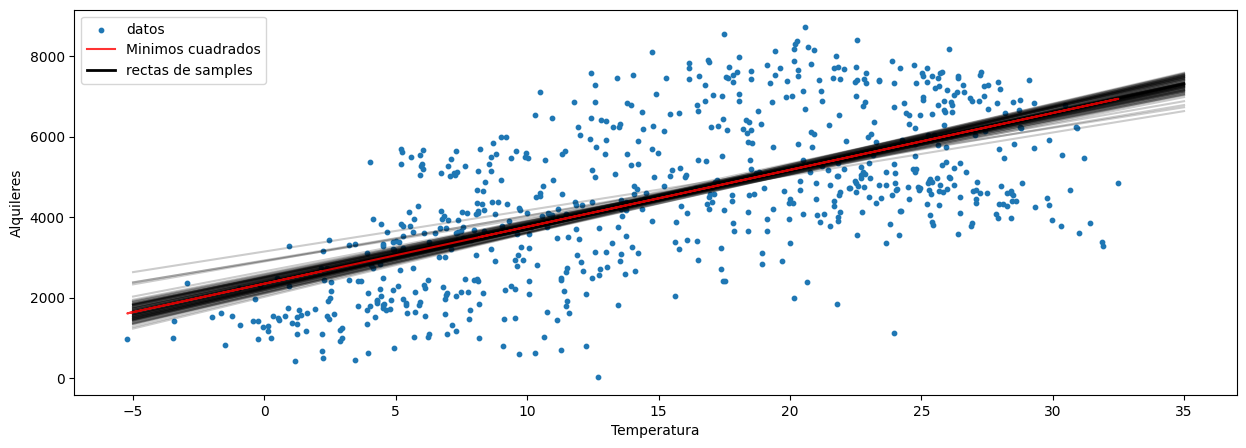



## Vemos que las rectas de la posterior tienden a centrarse a la recta de minimos cuadrados y que algunas de las rectas factibles tienen una pendiente mas baja y un intercepto mas alta



In [18]:
bikes_100_posteriors = bike_final_chain[np.random.choice(bike_final_chain.shape[0], 100, replace=False)]

plt.figure(figsize=(15, 5))

plt.scatter(df_bikes.temp, df_bikes.cnt, s=10, label = 'datos')

x = np.linspace(-5, 35, 100)

for i in range(len(bikes_100_posteriors)):
    plt.plot(x, bikes_100_posteriors[i, 0] + bikes_100_posteriors[i, 1] * x, color = 'black', alpha=0.2)

regression_line = np.polyval(np.polyfit(df_bikes.temp, df_bikes.cnt, 1), df_bikes.temp)
plt.plot(df_bikes.temp, regression_line, color='red', alpha= 0.8, label = 'Minimos cuadrados')


handles, labels = plt.gca().get_legend_handles_labels()
legend_item = Line2D([0], [0], label='rectas de samples', color='black', lw=2)
handles.append(legend_item)
plt.legend(handles=handles, labels=labels + ['rectas de samples'])

plt.xlabel('Temperatura')
plt.ylabel('Alquileres')
plt.show()



Markdown(fr"""

#### Vemos que las rectas de la posterior tienden a centrarse a la recta de minimos cuadrados y que algunas de las rectas factibles tienen una pendiente mas baja y un intercepto mas alta

""")

## G) Genere una distribucion posterior predictive para Y con algun X fijo. Utilicela para responder alguna pregunta relevante a sus datos.


### Cual es la probabilidad de que un dia de 20 grados tenga mas de 6000 alquileres de bicicletas?

In [19]:
# obtenemos 5000 samples de la posterior
bikes_5000_posteriors = bike_final_chain[np.random.choice(bike_final_chain.shape[0], 5000, replace=False)]

days_with_more_than_6000_rides = 0

for k in range(len(bikes_5000_posteriors)):
    posterior_sample = bikes_5000_posteriors[k]
    temperature_predicted = np.random.normal(posterior_sample[0] + posterior_sample[1] * 20, posterior_sample[2], 1)
    if temperature_predicted > 6000:
        days_with_more_than_6000_rides += 1


Markdown(fr"""

### La probabilidad de que el tiempo de alquiler de bicicletas sea mayor a 6000 es de {days_with_more_than_6000_rides/len(bikes_5000_posteriors)}.

""")




### La probabilidad de que el tiempo de alquiler de bicicletas sea mayor a 6000 es de 0.303.



### Cuantos alquileres de bicis voy a tener en un dia de 25 grados?

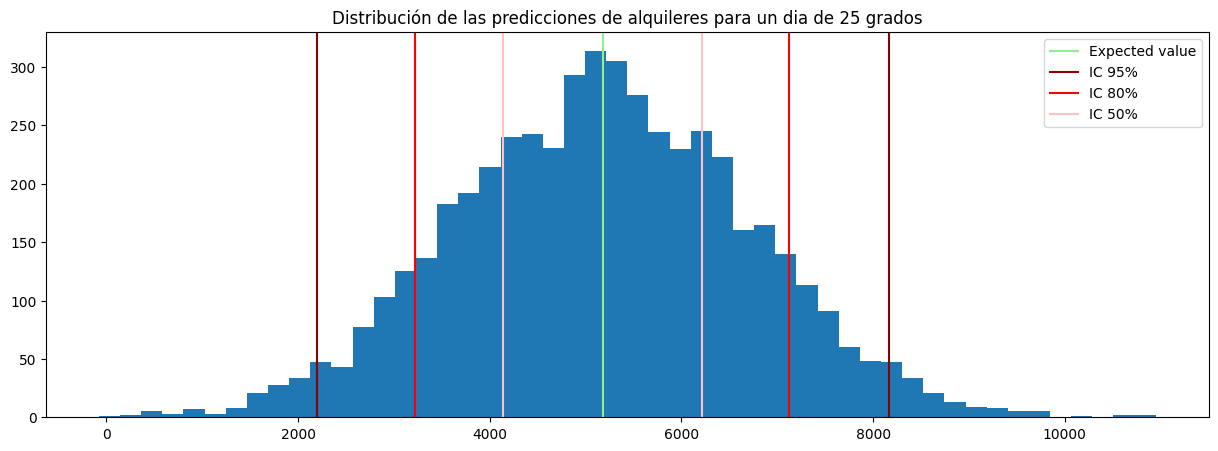



#### El expected value de un dia de 25 grados es de 5181.1009907624775
#### El intervalo de credibilidad del 50% es de (4134.480937614778, 6218.458839715507)
#### El intervalo de credibilidad del 80% es de (3220.275676101122, 7122.525998872484)
#### El intervalo de credibilidad del 95% es de (2195.032247848711, 8167.052544107038)



In [41]:
temperatures_predicted = np.array([])

for k in range(len(bikes_5000_posteriors)):
    posterior_sample = bikes_5000_posteriors[k]
    temperature_predicted = np.random.normal(posterior_sample[0] + posterior_sample[1] * 20, posterior_sample[2], 1)
    temperatures_predicted = np.append(temperatures_predicted, temperature_predicted)

plt.figure(figsize=(15, 5))

plt.title('Distribución de las predicciones de alquileres para un dia de 25 grados')

plt.hist(temperatures_predicted, bins=50)

percentil_50 = np.percentile(temperatures_predicted, 50)
percentil_2_5 = np.percentile(temperatures_predicted, 2.5)
percentil_10 = np.percentile(temperatures_predicted, 10)
percentil_25 = np.percentile(temperatures_predicted, 25)
percentil_75 = np.percentile(temperatures_predicted, 75)
percentil_90 = np.percentile(temperatures_predicted, 90)
percentil_97_5 = np.percentile(temperatures_predicted, 97.5)

plt.axvline(percentil_50, color = 'lightgreen', label = 'Expected value')

plt.axvline(percentil_2_5, color = 'darkred')
plt.axvline(percentil_97_5, color = 'darkred', label = 'IC 95%')

plt.axvline(percentil_10, color = 'red')
plt.axvline(percentil_90, color = 'red', label = 'IC 80%')

plt.axvline(percentil_25, color = 'pink')
plt.axvline(percentil_75, color = 'pink', label = 'IC 50%')

plt.legend()
plt.show()

Markdown(fr"""

#### El expected value de un dia de 25 grados es de {percentil_50}
#### El intervalo de credibilidad del 50% es de ({percentil_25}, {percentil_75})
#### El intervalo de credibilidad del 80% es de ({percentil_10}, {percentil_90})
#### El intervalo de credibilidad del 95% es de ({percentil_2_5}, {percentil_97_5})

""")


# Ejercicio 3

Para los mismos datos, mismo modelo y mismos priors del ejercicio 2, haga la regresion
lineal utilizando brms o un paquete similar.



## A) Grafique, utilizando el paquete, las cadenas marginales. Parecen haber convergido?


## B) Coinciden los posteriors marginales (los de cada parametro por separado) con los calculados en el ejercicio 2?

## C) Compute la respuesta al item G) del ejercicio 2. Coinciden estas respuestas?